In [2]:
import pandas as pd

# 데이터 불러오기

In [3]:
virtual_df = pd.read_excel('가상계좌_결제내역_2024.06.01-2024.06.24.xlsx')
credit_df = pd.read_excel('신용·체크카드_결제내역_2024.06.01-2024.06.24.xlsx')

C:\anaconda3\Lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
C:\anaconda3\Lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [4]:
tip = pd.read_csv('settlement_order_list_20240624_T.csv')
fie = pd.read_csv('settlement_order_list_20240624_F.csv')
rung = pd.read_csv('settlement_order_list_20240624_R.csv')
hung = pd.read_csv('settlement_order_list_20240624_H.csv')
lee = pd.read_csv('settlement_order_list_20240624_LEE.csv')

# 컬럼 정리 및 데이터 전처리

In [5]:
# 필요한 컬럼만 남기기
virtual_df = virtual_df[['결제·취소일시','취소완료일시','주문번호', '결제상태', '입금·취소액']]
credit_df = credit_df[['결제일시', '취소일시', '주문번호', '결제상태', '결제액','취소액']]

# 결제방법 구분하기 + 결제상태 컬럼 만들기
virtual_df['결제방법'] = '가상계좌'
credit_df['결제방법'] = '신용카드'

# 결제방법 컬럼을 앞으로 이동
virtual_df = virtual_df[['결제방법', '결제·취소일시','주문번호', '결제상태', '입금·취소액']]
credit_df = credit_df[['결제방법', '결제일시', '주문번호', '결제상태', '결제액','취소액']]

# '결제상태'가 '완료', '취소요청', '부분취소'인 행만 남기기
virtual_df = virtual_df[virtual_df['결제상태'].isin(['완료', '취소요청', '부분취소'])]
credit_df = credit_df[credit_df['결제상태'].isin(['완료', '취소', '부분취소'])]

# 취소건 처리

In [6]:
# 가상계좌 결제내역에서 취소하면 음수로 표시됨
# 신용카드 결제내역에서 취소하면 음수로 표시됨

In [7]:
# 취소금액 확인하기
# Filter out the rows where '입금·취소액' and '결제액' have been made negative due to cancellation
virtual_df_negatives = virtual_df[virtual_df['입금·취소액'] < 0]
credit_df_negatives = credit_df[credit_df['취소액'] < 0]

# Displaying a sample of the rows where adjustments have been made
virtual_df_negatives

,결제방법,결제·취소일시,주문번호,결제상태,입금·취소액


In [8]:
credit_df_negatives

,결제방법,결제일시,주문번호,결제상태,결제액,취소액


In [9]:
credit_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66 entries, 0 to 65
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   결제방법    66 non-null     object
 1   결제일시    66 non-null     object
 2   주문번호    66 non-null     object
 3   결제상태    66 non-null     object
 4   결제액     66 non-null     int64 
 5   취소액     66 non-null     int64 
dtypes: int64(2), object(4)
memory usage: 3.6+ KB


# 두개의 데이터 컬럼 일치 시키기

In [10]:
# 신용카드 취소액 결제액으로 옮기기
# 취소액이 있는 행을 복제합니다.
cancellation_rows = credit_df[credit_df['취소액'] < 0].copy()

# 복제한 행에서 '결제액'을 '취소액'으로 업데이트합니다.
cancellation_rows['결제액'] = cancellation_rows['취소액']

# 원본 DataFrame에 복제한 행을 추가합니다.
credit_df = pd.concat([credit_df, cancellation_rows], ignore_index=True)

# 취소액 컬럼 없애기
credit_df = credit_df[['결제방법', '결제일시', '주문번호', '결제상태', '결제액']]

# 결과 확인을 위해 처음 몇 행을 출력합니다.
credit_df.head(), cancellation_rows.head()

(   결제방법                 결제일시                   주문번호 결제상태      결제액
 0  신용카드  2024-06-24 14:33:18  3000001309-1719207197   완료    90400
 1  신용카드  2024-06-24 11:38:34  3000001308-1719196714   완료  1198900
 2  신용카드  2024-06-22 15:37:14  3000001303-1719038233   완료    99000
 3  신용카드  2024-06-21 16:45:21   000005080-1718955921   완료    81100
 4  신용카드  2024-06-21 16:09:09   000005074-1718953749   완료   143000,
 Empty DataFrame
 Columns: [결제방법, 결제일시, 주문번호, 결제상태, 결제액, 취소액]
 Index: [])

In [11]:
# 컬럼 명 일치시키기
credit_df = credit_df.rename(columns={'결제일시': '결제·취소일시', '결제액': '입금·취소액'})

# 데이터 합치기

In [12]:
combined_df = pd.concat([virtual_df, credit_df], ignore_index=True)

In [13]:
virtual_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 882 entries, 0 to 881
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   결제방법     882 non-null    object
 1   결제·취소일시  882 non-null    object
 2   주문번호     882 non-null    object
 3   결제상태     882 non-null    object
 4   입금·취소액   882 non-null    int64 
dtypes: int64(1), object(4)
memory usage: 41.3+ KB


In [14]:
credit_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66 entries, 0 to 65
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   결제방법     66 non-null     object
 1   결제·취소일시  66 non-null     object
 2   주문번호     66 non-null     object
 3   결제상태     66 non-null     object
 4   입금·취소액   66 non-null     int64 
dtypes: int64(1), object(4)
memory usage: 2.7+ KB


In [15]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 948 entries, 0 to 947
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   결제방법     948 non-null    object
 1   결제·취소일시  948 non-null    object
 2   주문번호     948 non-null    object
 3   결제상태     948 non-null    object
 4   입금·취소액   948 non-null    int64 
dtypes: int64(1), object(4)
memory usage: 37.2+ KB


In [16]:
combined_df

,결제방법,결제·취소일시,주문번호,결제상태,입금·취소액
0,가상계좌,2024-06-24 16:45:27,000005108-1719191813,완료,746400
1,가상계좌,2024-06-24 16:41:20,3000001310-1719208840,완료,333050
2,가상계좌,2024-06-24 16:37:55,000005129-1719207529,완료,63400
3,가상계좌,2024-06-24 16:37:54,000005128-1719207320,완료,567400
4,가상계좌,2024-06-24 16:35:43,000005136-1719214165,완료,481200
...,...,...,...,...,...
943,신용카드,2024-06-04 13:13:37,000004333-1717474417,완료,74350
944,신용카드,2024-06-03 15:45:05,3000001130-1717397105,완료,447100
945,신용카드,2024-06-03 12:52:41,3000001123-1717386760,완료,281900
946,신용카드,2024-06-03 12:51:54,3000001122-1717386714,완료,160000


In [17]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 948 entries, 0 to 947
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   결제방법     948 non-null    object
 1   결제·취소일시  948 non-null    object
 2   주문번호     948 non-null    object
 3   결제상태     948 non-null    object
 4   입금·취소액   948 non-null    int64 
dtypes: int64(1), object(4)
memory usage: 37.2+ KB


# 주문건에 이름붙이기

In [18]:
def adjust_order_number(order_number):
    # order_number를 문자열로 변환
    order_number_str = str(order_number)
    # "-"를 기준으로 분리하고 첫 번째 부분을 선택
    processed_order_number = order_number_str.split('-')[0]
    # 선택된 부분이 10자리인 경우는 그대로 반환
    if len(processed_order_number) == 10:
        return processed_order_number
    # 9자리 미만인 경우, 9자리가 되도록 앞쪽을 0으로 채움
    elif len(processed_order_number) < 9:
        return processed_order_number.zfill(9)
    # 그 외의 경우 (즉, 9자리인 경우), 그대로 반환
    else:
        return processed_order_number

In [19]:
# combined_df의 '주문번호' 컬럼에 정의한 함수 적용
combined_df['주문번호'] = combined_df['주문번호'].apply(adjust_order_number)

In [20]:
# 각 데이터프레임의 'Order No' 컬럼에 adjust_order_number 함수 적용
for df in [tip, rung, fie, hung]:
    df['Order No'] = df['Order No'].apply(adjust_order_number)

In [21]:
# 각 엑셀 파일에 'operator' 컬럼 추가하고, 파일명에 따라 해당하는 값을 할당하기
fie['operator'] = 'fie'
hung['operator'] = 'hung'
rung['operator'] = 'rung'
tip['operator'] = 'tip'
lee['operator'] = 'lee'

In [22]:
# '고객 이름' 컬럼이 모든 파일에 있다고 가정하고, 필요한 컬럼만 선택하기
# 여기서 '고객명'이 고객 이름을 나타내는 컬럼이라고 가정합니다. 실제 컬럼 이름에 맞게 조정해 주세요.
fie = fie[['Order No', '고객 이름', 'operator']]
hung = hung[['Order No', '고객 이름', 'operator']]
rung = rung[['Order No', '고객 이름', 'operator']]
tip = tip[['Order No', '고객 이름', 'operator']]
lee = lee[['Order No', '고객 이름', 'operator']]

In [23]:
# 모든 엑셀 파일을 하나의 데이터프레임으로 합치기
source_dfs_combined = pd.concat([fie, hung, rung, tip,lee])
source_dfs_combined = source_dfs_combined.drop_duplicates(subset=['Order No'], keep='first')

In [24]:
# '주문번호' 컬럼을 'Order No'로 이름 변경
combined_df.rename(columns={'주문번호': 'Order No'}, inplace=True)

In [25]:
# 병합 시 'operator' 컬럼과 '고객 이름' 컬럼을 활용해 각 주문이 어느 파일에서 왔는지와 고객 이름을 표시하기
merged_df = pd.merge(combined_df, source_dfs_combined[['Order No', '고객 이름', 'operator']], on='Order No', how='left')

In [26]:
merged_df

,결제방법,결제·취소일시,Order No,결제상태,입금·취소액,고객 이름,operator
0,가상계좌,2024-06-24 16:45:27,000005108,완료,746400,1_이수진 _T,tip
1,가상계좌,2024-06-24 16:41:20,3000001310,완료,333050,1_농림상사 _H,hung
2,가상계좌,2024-06-24 16:37:55,000005129,완료,63400,1_띵동마트 _R,rung
3,가상계좌,2024-06-24 16:37:54,000005128,완료,567400,1_난 타이 마트 _F,fie
4,가상계좌,2024-06-24 16:35:43,000005136,완료,481200,1_최윤석 _T,tip
...,...,...,...,...,...,...,...
943,신용카드,2024-06-04 13:13:37,000004333,완료,74350,NaN,NaN
944,신용카드,2024-06-03 15:45:05,3000001130,완료,447100,1_ 피셋 _H,hung
945,신용카드,2024-06-03 12:52:41,3000001123,완료,281900,1_ 창타이누들 _H,hung
946,신용카드,2024-06-03 12:51:54,3000001122,완료,160000,1_ 알로이 _H,hung


In [27]:
merged_df.to_excel('6월 정산_0501.xlsx', index=False)

# EDA

In [28]:
# Excel 파일 불러오기
df = pd.read_excel('6월 정산_0524_final.xlsx')

In [29]:
# Operator 별 금액 집계
operator_amounts = df.groupby('operator')['입금·취소액'].sum()

# 고객 이름 별 금액 집계
customer_amounts = df.groupby('고객 이름')['입금·취소액'].sum()

# 결과 출력
print("Operator 별 금액:")
print(operator_amounts)

print("고객 이름 별 금액:")


Operator 별 금액:
operator
fie     58585400
hung    66649550
rung    37264350
tip     41433700
Name: 입금·취소액, dtype: int64
고객 이름 별 금액:


In [30]:
customer_amounts

고객 이름
 S22068_F Pairin Thonchauy      74350
1_ 88마트 _R                    1449700
1_ Lee sang _F                  59000
1_ Phen _F                     311000
1_ Tongyai _F                  282400
                               ...   
테이스트타일랜드 _T                    317900
팟 타이 랜드 _R                     361800
포니케이크 _T                       108800
한한 _R                          700800
헹헹 _F                          219500
Name: 입금·취소액, Length: 274, dtype: int64

C:\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 44552 (\N{HANGUL SYLLABLE GEUM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 50529 (\N{HANGUL SYLLABLE AEG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


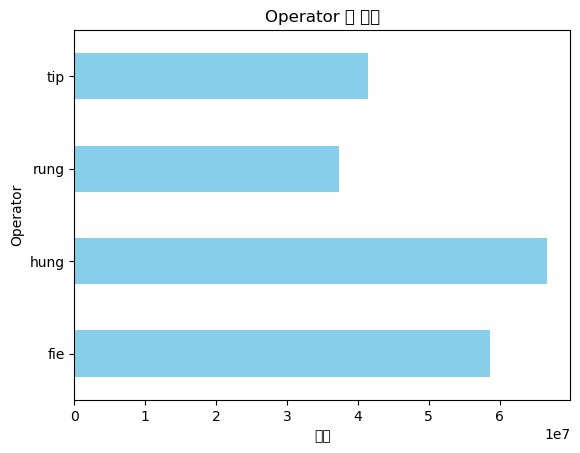

In [31]:
import matplotlib.pyplot as plt

# Operator 별 금액 시각화
operator_amounts.plot(kind='barh', color='skyblue')
plt.title('Operator 별 금액')
plt.xlabel('금액')
plt.ylabel('Operator')
plt.show()

In [32]:
# Excel 파일로 저장
with pd.ExcelWriter('6월 담당자별.xlsx') as writer:
    operator_amounts.to_excel(writer, sheet_name='담당자별')
    customer_amounts.to_excel(writer, sheet_name='거래처별')

print("엑셀 파일이 생성되었습니다.")

엑셀 파일이 생성되었습니다.


# 과세 면세 세액 확인

In [18]:
# 여신금액 합친 데이터 불러오기
toss_df = pd.read_excel('4월 매출 원 데이터.xlsx')
# 사이트 매출 불러오기
site_df = pd.read_csv('settlement_order_summary_20240401.csv')

In [19]:
# 토스 데이터를 고객 이름 별로 묶기
toss_customer_df = toss_df.groupby(['고객 이름', '결제방법', 'operator'])['입금·취소액'].sum().reset_index()

## site_df 가 믿을만 한가?

In [20]:
toss_customer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421 entries, 0 to 420
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   고객 이름     421 non-null    object
 1   결제방법      421 non-null    object
 2   operator  421 non-null    object
 3   입금·취소액    421 non-null    int64 
dtypes: int64(1), object(3)
memory usage: 13.3+ KB


In [17]:
site_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 267 entries, 0 to 266
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   관리자                     267 non-null    object 
 1   Customer ID             267 non-null    int64  
 2   고객 이름                   267 non-null    object 
 3   Point (taxation)        267 non-null    float64
 4   Point (tax)             267 non-null    float64
 5   Point (tax exemption)   267 non-null    int64  
 6   Point total             267 non-null    int64  
 7   Vbank (taxation)        267 non-null    float64
 8   Vbank (tax)             267 non-null    float64
 9   Vbank (tax exemption)   267 non-null    int64  
 10  Vbank total             267 non-null    int64  
 11  Card (taxation)         267 non-null    float64
 12  Card (tax)              267 non-null    float64
 13  Card (tax exemption)    267 non-null    int64  
 14  Card total              267 non-null    in

토스에서 뽑아낸 고객이름은 421명인데 반해 site_df에서는 267개 정도 밖에 안된다. <br>
이름이 다르거나 site_df에서 누락된 금액이 저정도가 되는 것이다.

정확히 어떤 고객이 누락되었는지 알아보자.

In [28]:
# 'toss_customer_df'에서 '고객 이름'을 기준으로 'site_df'와 일치하지 않는 데이터 찾기
unmatched_names = set(toss_customer_df['고객 이름']) - set(site_df['고객 이름'])

# 일치하지 않는 고객 이름을 가진 행만 필터링
unmatched_customers = toss_customer_df[toss_customer_df['고객 이름'].isin(unmatched_names)]

In [29]:
unmatched_customers

,고객 이름,결제방법,operator,입금·취소액
57,1_SINGHA_R,여신,rung,1987400
70,1_크루아타이깐엥 _H,신용카드,hung,124400
75,1_타이피농 _사 _T,가상계좌,tip,72400
82,Asia mart Manseon S23011_F_사,가상계좌,fie,214800
84,CHANOKNAN S20259_T,가상계좌,fie,2731000
...,...,...,...,...
415,포야이 아시아마트 _R_사,가상계좌,rung,49600
416,피크닉박스 _H,가상계좌,hung,146200
417,행운 _F,가상계좌,fie,5053500
418,호원코퍼레이션 _H,가상계좌,hung,610300


# 그래도 배송비를 구해보자

In [21]:
# site 데이터와 toss 데이터를 고객이름 기준으로 묶기. 금액은 합치기
merged_df = pd.merge(site_df, toss_customer_df[['고객 이름', '입금·취소액']], on='고객 이름', how='left')

# 배송비 구하기
merged_df['배송비'] = merged_df['입금·취소액'] - merged_df['총합계']

In [26]:
# 고객이름 불일치 
unmatched_entries = merged_df['입금·취소액'].isna()
# 불일치 하면 배송비는 0으로 채움
merged_df['배송비'].fillna(0, inplace=True)

In [23]:
# 배송비 업데이트
site_df['배송비'] = merged_df['배송비']

In [25]:
site_df.to_excel('배송비를 구해보자.xlsx', index=False)

In [30]:
site_df

,관리자,Customer ID,고객 이름,Point (taxation),Point (tax),Point (tax exemption),Point total,Vbank (taxation),Vbank (tax),Vbank (tax exemption),...,Card total,Refund (taxation),Refund (tax),Refund (tax exemption),Refund total,Total (taxation),Total (tax),Total (tax exemption),총합계,배송비
0,팁 팁 (ID: 17),1074100938,KHUNAROOP _T,0.0,0.0,0,0,46999.99,4700.01,9200,...,0,0.0,0.0,0,0.0,46999.99,4700.01,9200,60900.0,0.0
1,팁 팁 (ID: 17),1082964075,Kehasathan Daranporn _T,0.0,0.0,0,0,3805005.97,380044.03,1566250,...,0,0.0,0.0,0,0.0,3805005.97,380044.03,1566250,5751300.0,-3784600.0
2,팁 팁 (ID: 17),1043629971,MAYOE CHAR _T,0.0,0.0,0,0,0.00,0.00,54000,...,0,0.0,0.0,0,0.0,0.00,0.00,54000,54000.0,0.0
3,룽 룽 (ID: 16),1059314333,KAMALASK _R,0.0,0.0,0,0,2920727.37,292072.63,963100,...,0,0.0,0.0,0,0.0,2920727.37,292072.63,963100,4175900.0,-3307300.0
4,팁 팁 (ID: 17),1076580677,MEETHONG NATTHAPREEYA _T,0.0,0.0,0,0,260272.77,26027.23,25600,...,0,0.0,0.0,0,0.0,260272.77,26027.23,25600,311900.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262,룽 룽 (ID: 16),1083043547,밍 _R,0.0,0.0,0,0,55636.36,5563.64,0,...,0,0.0,0.0,0,0.0,55636.36,5563.64,0,61200.0,8000.0
263,팁 팁 (ID: 17),1026014846,온이 _T,0.0,0.0,0,0,57636.37,5763.63,0,...,0,0.0,0.0,0,0.0,57636.37,5763.63,0,63400.0,16000.0
264,룽 룽 (ID: 16),1027117131,신피양펜 _R,0.0,0.0,0,0,119636.35,11963.65,0,...,0,0.0,0.0,0,0.0,119636.35,11963.65,0,131600.0,0.0
265,파이 파이 (ID: 20),1058633088,F Tongyai _F,0.0,0.0,0,0,90545.46,9054.54,0,...,0,0.0,0.0,0,0.0,90545.46,9054.54,0,99600.0,4000.0


# 오과장님 결제 내역과 비교해보기

In [1]:
from openpyxl import load_workbook

# Create a new Workbook for the updated data
updated_wb = Workbook()
updated_ws = updated_wb.active
updated_ws.title = "Additional Rows in New File 1"

# Add the new mismatched rows
for row in new_mismatched_rows_wb1:
    updated_ws.append(row)

# Save the workbook
updated_output_path = '/mnt/data/updated_additional_rows.xlsx'
updated_wb.save(updated_output_path)

updated_output_path

C:\anaconda3\Lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


(94,
 1526,
 [('상점아이디(MID)',
   '결제일시',
   '취소일시',
   '주문번호',
   '결제상태',
   '구매자명',
   '결제액',
   '취소액',
   '결제수단',
   '결제기관',
   '구매상품',
   '안내메시지',
   '승인번호',
   '취소자'),
  ('kvp_darlra4f33',
   '2024-03-30 19:05:36',
   None,
   '3000000475-1711793136',
   '완료',
   '1********H',
   67000.0,
   0.0,
   '일반',
   '삼성',
   'Dalrat 3000000475',
   '거래성공',
   '96073043',
   None),
  ('kvp_darlra4f33',
   '2024-03-29 16:47:15',
   None,
   '3000000474-1711698435',
   '완료',
   'S2************시아',
   287400.0,
   0.0,
   '일반',
   '신한',
   'Dalrat 3000000474',
   '거래성공',
   '31600433',
   None),
  ('kvp_darlra4f33',
   '2024-03-29 16:16:57',
   None,
   '3000000473-1711696617',
   '완료',
   'S2************외동',
   53400.0,
   0.0,
   '일반',
   '삼성',
   'Dalrat 3000000473',
   '거래성공',
   '18274327',
   None),
  ('kvp_darlra4f33',
   '2024-03-29 14:52:09',
   None,
   '3000000470-1711691528',
   '완료',
   'S2************외동',
   81800.0,
   0.0,
   '일반',
   '삼성',
   'Dalrat 3000000470',
   '거래성공',
   